In [9]:
import numpy as np

from scipy.sparse.linalg import spsolve
from scipy.sparse        import diags, hstack, vstack

from CoolProp.CoolProp import PropsSI

import matplotlib.pyplot as plt
from matplotlib import rc, rcParams

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
rcParams.update({'font.size': 18})
rcParams['figure.figsize']   = [8,6]
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family']      = 'STIXGeneral'

# Heat exchanger model 


Energy equation: 
$$c_p m \frac{dT}{dx} - A \frac{d}{dx}\left(k\frac{dT}{dx}\right) = P h \Delta T$$

In discretized form: 
$$-\left(\frac{A k_m}{\Delta x^2}-\frac{c_p m}{2\Delta x}\right)T_{i-1} + \left(\frac{A(k_m+k_p)}{\Delta x^2}\right)T_{i} + \left(-\frac{A k_p}{\Delta x^2}+\frac{c_p m}{2\Delta x}\right)T_{i+1}= P h \left(T_{ref}-T_i\right)$$ 

### Build linear system of equations for the energy equation

The energy equation in discretized form is

$$c_\text{ld}T_{i-1} + (c_d + Ph) T_{i} + c_{ud}T_{i+1} = Ph T_{ref},$$

where $c_{ld}$ is the coefficient at the 'lower diagonal', $c_d$ at 'diagonal' and $c_{ud}$ at the 'upper diagonal of the linear matrix system. 

The linear system is then

$$
\begin{bmatrix}
c_d & c_{ud} & 0 & \dots & 0\\
c_{ld} & c_{d} & c_{ud} & \ddots  & \vdots \\
0 & c_{ld} & c_{d} & \ddots  & \vdots \\
\vdots & \ddots  & \ddots  & \ddots & \vdots \\
0 & \dots & \dots & c_{ld} & c_{d}   \\
\end{bmatrix} 
\begin{bmatrix}T_1 \\ \vdots\\ T_{N-2} \end{bmatrix}
= 
\begin{bmatrix}
-c_{ld} \cdot T_{0} \\
\vdots\\
-c_{ud} \cdot T_{N-1} 
\end{bmatrix} .
$$

In [10]:
def buildLinSys(T, U, fluid, dx, advecScheme):
    
    npts = np.size(T)
        
    # these should be functions of temperature
    cp = PropsSI('C', "T", T, "P", fluid['pressure'], fluid['fluid'])
#     k  = PropsSI('L', "T", T, "P", fluid['pressure'], fluid['fluid'])
    k  = 1.0*np.ones(npts) #PropsSI('L', "T", T, "P", pressure, fluid)
    
    # calculate average k at the faces 
    # 0 ... kave[0] ... 1 ... kave[1] ... 2 ... kave[2] ....... 
    k_f = 0.5*(k[0:-1] + k[1:])*A/dx**2
    
    mf = fluid['mass flow']
    if advecScheme == "central":
        mfPl = mf/(2*dx)
        mfMi = mf/(2*dx)
    if advecScheme == "upwind":
        mfPl = (mf+abs(mf))/(2*dx)
        mfMi = (mf-abs(mf))/(2*dx)

    ud = - k_f[1:  ]            + cp[1:-1]* mfMi 
    d  =  (k_f[1:  ]+k_f[0:-1]) + cp[1:-1]*(mfPl-mfMi) + U[1:-1]*Per
    ld = - k_f[0:-1]            - cp[1:-1]* mfPl      
    
    rhs = np.zeros(npts-2)

    # add BC's 
    if mf > 0.0: # Dirichlet at the inlet (left), extrapolate at the outlet (right)
        d[-1]   =  d[-1] + 2*ud[-1]
        ld[-1]  = ld[-1] -   ud[-1]
        rhs[ 0] = (k_f[ 0] + mfPl*cp[ 1]) * T[ 0]
    else:        # Dirichlet at the i nlet (right), extrapolate at the outlet (left)
        d[0]    = ( d[0] + 2*ld[0])
        ud[0]   = (ud[0] -   ld[0])
        rhs[-1] = (k_f[-1] - mfMi*cp[-2]) * T[-1]
                  
    # assemble main A matrix 
    ud   = diags(    ud,  1, shape=(npts-2,npts-2))
    d    = diags(     d,  0, shape=(npts-2,npts-2))
    ld   = diags(ld[1:], -1, shape=(npts-2,npts-2))
    Amat = ud + d + ld
    
    return Amat,rhs

### Coupled solver

Both energy equations can also be solved in a coupled manner. Then 

$$ \mathbf A_c \cdot T_c - P h T_h = rhs_c $$
$$ \mathbf A_h \cdot T_h - P h T_c = rhs_h ,$$

which in matrix form looks like

$$ \begin{bmatrix} 
 [\mathbf A_c] & 
                     \begin{bmatrix}
                     P h_c &  & \\
                      & \ddots & \\
                     &  & P h_c \\
                     \end{bmatrix} 
 \\
                     \begin{bmatrix}
                     P h_h &  & \\
                      & \ddots & \\
                     &  & P h_h \\
                 \end{bmatrix} & [A_h]&\\
\end{bmatrix} 
\begin{bmatrix} 
T_{c,1} \\ \vdots \\ T_{c,N-2} \\ T_{h,1} \\ \vdots \\ T_{h,N-2} \\ 
\end{bmatrix} = rhs .
$$

Note, $rhs$ only contains the BC's for the temperatures $T_c$ and $T_h$. 

The equations are solved with an under-relaxation parameter $\omega$. Then the linear system is

$$ \left(\mathbf A +\frac{1-\omega}{\omega}\mathbf A_{ii}\right)\cdot T^{k+1} = rhs + \frac{1-\omega}{\omega}\mathbf A_{ii} \cdot T^{k} .$$ 


In [11]:
def solveHEX(colFluid, hotFluid, length, npts=None, advecScheme='central', 
             underrelax=0.8, maxiter=1000, tol=1.0e-3, printResiduals=False):

    if npts is None: # then calculate npts based on dx=0.04
        npts = min(max(int(length/0.04),30), 400) 

    Tc = np.ones(npts)*colFluid['inlet temp']
    Th = np.ones(npts)*hotFluid['inlet temp']
    
    U  = valueU*np.ones(npts)
    
    x  = np.linspace(0.0, length, npts)
    dx = x[1] - x[0]
    
    itera = 0
    res   = 1.0e10

    while itera < maxiter and res > tol:

        AmatTc, rhsTc = buildLinSys(Tc, U, colFluid, dx, advecScheme)
        AmatTh, rhsTh = buildLinSys(Th, U, hotFluid, dx, advecScheme)
        
        diagTc = diags(-U[1:-1]*Per, 0, shape=(npts-2,npts-2))
        diagTh = diags(-U[1:-1]*Per, 0, shape=(npts-2,npts-2))
        Amat = vstack([hstack([AmatTc,diagTc]),hstack([diagTh,AmatTh])], 'csr')
        
        rhs  = np.concatenate((rhsTc,rhsTh),axis=0)
        temp = np.concatenate((Tc[1:-1],Th[1:-1]),axis=0)

        # under-relaxation
        rhs = rhs + (1-underrelax)/underrelax*Amat.diagonal()*temp
        Amat.setdiag(Amat.diagonal()/underrelax)
        
        # solve and check convergence
        oldT = temp.copy()
        temp = spsolve(Amat, rhs)
        res  = np.linalg.norm(temp-oldT)/npts
        
        # put solution into Tc and Th arrays
        Tc[1:-1] = temp[:npts-2]
        Th[1:-1] = temp[npts-2:]
        
        # fix BC's
        if colFluid['mass flow'] > 0.0:  Tc[-1] = 2*Tc[-2] - Tc[-3]
        else:                            Tc[ 0] = 2*Tc[ 1] - Tc[ 2]

        if hotFluid['mass flow'] > 0.0:  Th[-1] = 2*Th[-2] - Th[-3]
        else:                            Th[ 0] = 2*Th[ 1] - Th[ 2]

        if itera%100 == 0 and printResiduals == True: 
            print("iter: ",itera, ", resid = ", res)

        itera += 1
          
    if printResiduals == True:
        print("iter: ",itera, ", resid = ", res,"\n")

    return x, Tc, Th

# Examples
## Check mesh dependency, advection scheme, etc.

iter:  0 , resid =  3.6781038088953837
iter:  73 , resid =  0.0009771375292058247 

iter:  0 , resid =  3.6781038088953837
iter:  100 , resid =  2.1549466867869915e-05
iter:  124 , resid =  9.289685178889193e-07 

iter:  0 , resid =  2.0138877226063725
iter:  100 , resid =  0.0014761472182037603
iter:  197 , resid =  9.62656868474849e-07 

iter:  0 , resid =  0.8905437518131736
iter:  100 , resid =  0.008628900943836637
iter:  200 , resid =  0.0028589581040733337
iter:  300 , resid =  0.0006693281150035443
iter:  400 , resid =  0.00014065695112059726
iter:  500 , resid =  2.878060075342577e-05
iter:  600 , resid =  5.848013248584404e-06
iter:  700 , resid =  1.1865629915510797e-06
iter:  712 , resid =  9.955905620791473e-07 



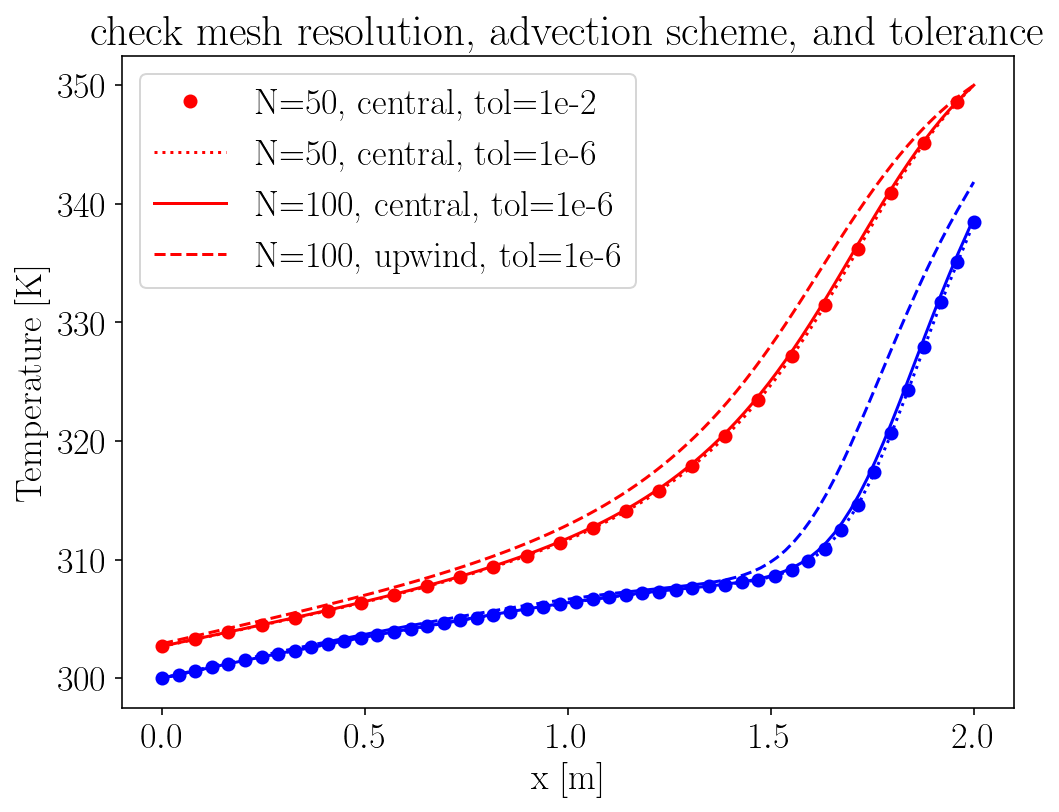

In [12]:
valueU = 2860.0
Per    = 0.4
A      = 1.0

colFluid = {'fluid'     : 'CO2', 
             'pressure'  : 80e5, 
             'inlet temp': 300,
             'mass flow' : 0.1}

hotFluid = {'fluid'     : 'Water', 
            'pressure'  : 1.0e5, 
            'inlet temp': 350, 
            'mass flow' : -0.1}

length = 2

# first case
#
x, Tc, Th = solveHEX(colFluid, hotFluid, length, npts=50, advecScheme="central",
                     underrelax=0.8, tol=1.0e-3, printResiduals=True)
l1, = plt.plot(x[::2],Th[::2],'ro')
plt.plot(x,Tc,'bo')


# second case
#
x, Tc, Th = solveHEX(colFluid, hotFluid, length, npts=50, advecScheme="central",
                     underrelax=0.8, tol=1.0e-6, printResiduals=True)
l2, = plt.plot(x,Th,'r:')
plt.plot(x,Tc,'b:')


# third case
#
x, Tc, Th = solveHEX(colFluid, hotFluid, length, npts=100, advecScheme="central",
                     underrelax=0.8, tol=1.0e-6, printResiduals=True)
l3, = plt.plot(x,Th,'r-')
plt.plot(x,Tc,'b-')


# fourth case
#
x, Tc, Th = solveHEX(colFluid, hotFluid, length, npts=100, advecScheme="upwind",
                     underrelax=0.8, tol=1.0e-6, printResiduals=True)
l4, = plt.plot(x,Th,'r--')
plt.plot(x,Tc,'b--')


plt.legend([l1,l2,l3,l4],['N=50,  central, tol=1e-2', 
                          'N=50,  central, tol=1e-6', 
                          'N=100, central, tol=1e-6', 
                          'N=100, upwind,  tol=1e-6'])
plt.title('check mesh resolution, advection scheme, and tolerance')
plt.xlabel("x [m]")
plt.ylabel("Temperature [K]");

### Calculate exergetic efficiency (NOT SURE IF THIS IS CORRECT!!!)

Exergy balance equation:
$$\Delta e = \int_0^L (h - T_0 s)dx$$

Epsilon: 
$$ \varepsilon = \frac{\dot m_c \Delta e_c}{\dot m_h \Delta e_h}$$

In [13]:
import scipy.integrate as integrate

def exerEfficiency(x, colFl, hotFl, Tc, Th, T0):

    # get enthalpy
    h_c = PropsSI('H', "T", Tc, "P", colFl['pressure'], colFl['fluid'])
    h_h = PropsSI('H', "T", Th, "P", hotFl['pressure'], hotFl['fluid'])

    # get entropy
    s_c = PropsSI('S', "T", Tc, "P", colFl['pressure'], colFl['fluid'])
    s_h = PropsSI('S', "T", Th, "P", hotFl['pressure'], hotFl['fluid'])

    DeltaE_c = integrate.simps((h_c-h_c[0]) - T0*(s_c-s_c[0]),x)
    DeltaE_h = integrate.simps((h_h-h_h[0]) - T0*(s_h-s_h[0]),x)

    DeltaE_c *= colFl['mass flow']
    DeltaE_h *= hotFl['mass flow']
    
    return abs(DeltaE_c/DeltaE_h)*100

eps = exerEfficiency(x, colFluid, hotFluid, Tc, Th, 283.15)
print('exergetic efficiency, eps = ', eps)

exergetic efficiency, eps =  77.90647859540188


## Example: water-cooled supercritical CO2 power cycle, determine length
Determine length to obtain desired outlet temperature of CO2

Length = 11.465161, CO2 out = 290.439018, deltaTsq = 20.802553
Length = 18.544839, CO2 out = 289.898757, deltaTsq = 26.022680
Length = 7.089679, CO2 out = 291.243219, deltaTsq = 14.113405
Length = 4.385482, CO2 out = 292.846459, deltaTsq = 4.637741
Length = 2.714197, CO2 out = 295.894239, deltaTsq = 0.799664
Length = 1.681285, CO2 out = 300.147914, deltaTsq = 26.501016
Length = 3.352571, CO2 out = 294.359868, deltaTsq = 0.409769
Length = 3.141882, CO2 out = 294.786276, deltaTsq = 0.045678
Length = 3.089226, CO2 out = 294.906553, deltaTsq = 0.008732
Length = 3.025550, CO2 out = 295.058938, deltaTsq = 0.003474
Length = 3.049628, CO2 out = 294.999826, deltaTsq = 0.000000
Length = 3.050180, CO2 out = 294.998530, deltaTsq = 0.000002
Length = 3.049584, CO2 out = 294.999931, deltaTsq = 0.000000
Length = 3.049554, CO2 out = 295.000000, deltaTsq = 0.000000
Length = 3.049558, CO2 out = 294.999992, deltaTsq = 0.000000
Length = 3.049551, CO2 out = 295.000008, deltaTsq = 0.000000
length =  3.049554

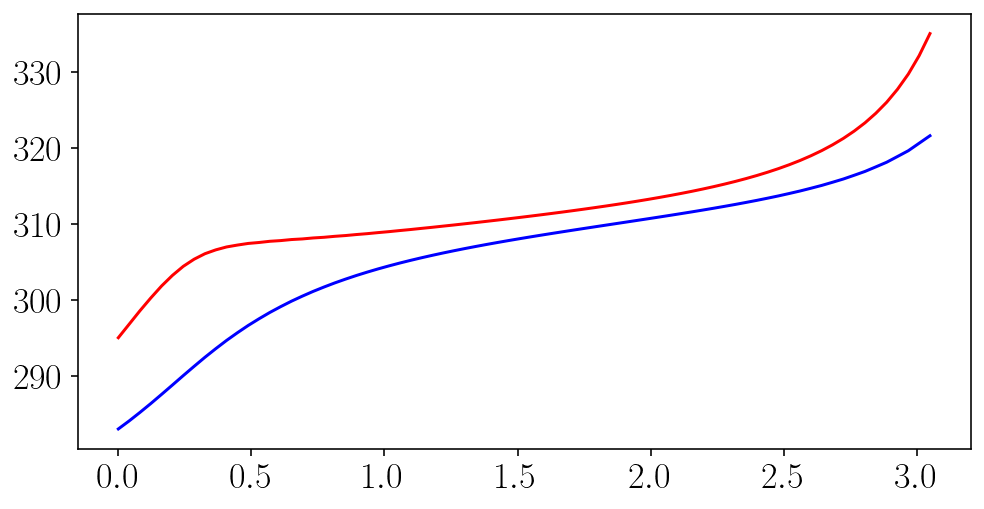

In [14]:
from scipy import optimize

valueU = 2860.0
Per    = 0.4
A      = 1.0

colFluid = {'fluid'     : 'Water', 
            'pressure'  : 1.0e5, 
            'inlet temp': 283,
            'mass flow' : 0.13}

hotFluid = {'fluid'     : 'CO2', 
            'pressure'  : 80.0e5, 
            'inlet temp': 335, 
            'mass flow' : -0.1}


TargetTempCO2Out = 295


def evalDeltaT_Length(length, mfWater, verbose):
    colFluid['mass flow'] = mfWater
    x, Tc, Th = solveHEX(colFluid, hotFluid, length)
    deltaT = (TargetTempCO2Out - Th[0])**2
    if verbose:
        print("Length = %.6f, CO2 out = %.6f, deltaTsq = %.6f" % (length, Th[0], deltaT))
    return deltaT

length = optimize.minimize_scalar(evalDeltaT_Length, 
                                  args=(colFluid['mass flow'], True), # additional args of evalDeltaT_Length
                                  bounds=(0.01, 30), 
                                  method='bounded').x

print('length = ', length, '\n')

x, Tc, Th = solveHEX(colFluid, hotFluid, length)
plt.figure(figsize=(8,4))
plt.plot(x,Tc,'b-')
plt.plot(x,Th,'r-')

eps = exerEfficiency(x, colFluid, hotFluid, Tc, Th, 283.15)
print('exergetic efficiency, eps = ', eps)

## Example: as before, but determine coolant (water) mass flow 

massflowWater = 0.388146, CO2 out = 283.000167, deltaTsq = 143.995982
massflowWater = 0.621854, CO2 out = 282.999924, deltaTsq = 144.001824
massflowWater = 0.243707, CO2 out = 283.001481, deltaTsq = 143.964453
massflowWater = 0.154439, CO2 out = 285.060663, deltaTsq = 98.790418
massflowWater = 0.099268, CO2 out = 302.391990, deltaTsq = 54.641511
massflowWater = 0.065171, CO2 out = 307.473218, deltaTsq = 155.581169
massflowWater = 0.120342, CO2 out = 296.725267, deltaTsq = 2.976546
massflowWater = 0.122658, CO2 out = 295.908278, deltaTsq = 0.824968
massflowWater = 0.128632, CO2 out = 293.811351, deltaTsq = 1.412888
massflowWater = 0.124940, CO2 out = 295.125013, deltaTsq = 0.015628
massflowWater = 0.125244, CO2 out = 295.014264, deltaTsq = 0.000203
massflowWater = 0.125308, CO2 out = 294.990999, deltaTsq = 0.000081
massflowWater = 0.125283, CO2 out = 294.999983, deltaTsq = 0.000000
massflowWater = 0.125280, CO2 out = 295.001203, deltaTsq = 0.000001
massflowWater = 0.125287, CO2 out = 29

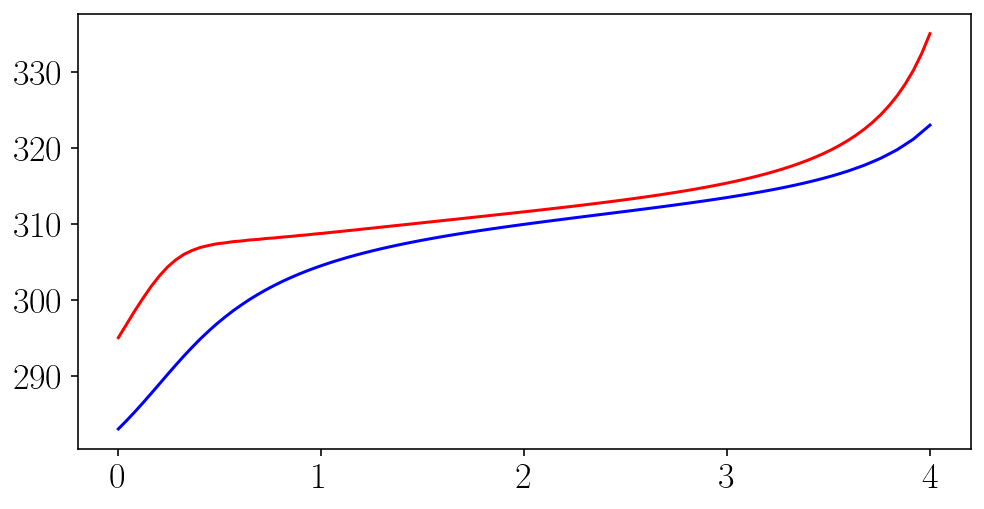

In [15]:
def evalDeltaT_massflow(massflowWater, length, verbose):
    colFluid['mass flow'] = massflowWater
    x, Tc, Th = solveHEX(colFluid, hotFluid, length)
    deltaT = (TargetTempCO2Out - Th[0])**2
    if verbose:
        print("massflowWater = %.6f, CO2 out = %.6f, deltaTsq = %.6f" % (colFluid['mass flow'], Th[0], deltaT))
    return deltaT


TargetTempCO2Out = 295

length = 4

massflowWater = optimize.minimize_scalar(evalDeltaT_massflow, 
                                         args=(length, True),
                                         bounds=(0.01, 1.0), 
                                         method='bounded').x

               
print('massflowWater = ', massflowWater, '\n')

colFluid['mass flow'] = massflowWater
x, Tc, Th = solveHEX(colFluid, hotFluid, length)
plt.figure(figsize=(8,4))
plt.plot(x,Tc,'b-')
plt.plot(x,Th,'r-')

eps = exerEfficiency(x, colFluid, hotFluid, Tc, Th, 283.15)
print('exergetic efficiency, eps = ', eps)

## Example: investigate exergetic eff as a function of L 

Allocate an array of lengths from $L_1$ to $L_2$. 

The run an optimization for each $L$ to get the mass flow rate $\dot m_{\textrm{water}}$ which gives the desired CO$_2$ outlet temperature.  

In [16]:
TargetTempCO2Out = 290

length_arr  = np.linspace(2, 6, 10)
eps_arr     = []
mfWater_arr = []
x_arr       = []
Tc_arr      = []
Th_arr      = []

for i,length in enumerate(length_arr):
    mfWater = optimize.minimize_scalar(evalDeltaT_massflow, 
                                       args=(length,False),       # pass length of HEX here!!
                                       bounds=(0.01, 0.5), 
                                       method='bounded').x
    colFluid['mass flow'] = mfWater
    x, Tc, Th = solveHEX(colFluid, hotFluid, length)
    eps = exerEfficiency(x, colFluid, hotFluid, Tc, Th, 283.15)
    
    mfWater_arr.append(mfWater)
    x_arr.append(x)
    Tc_arr.append(Tc)
    Th_arr.append(Th)
    eps_arr.append(eps)

Text(0, 0.5, 'temperature water out')

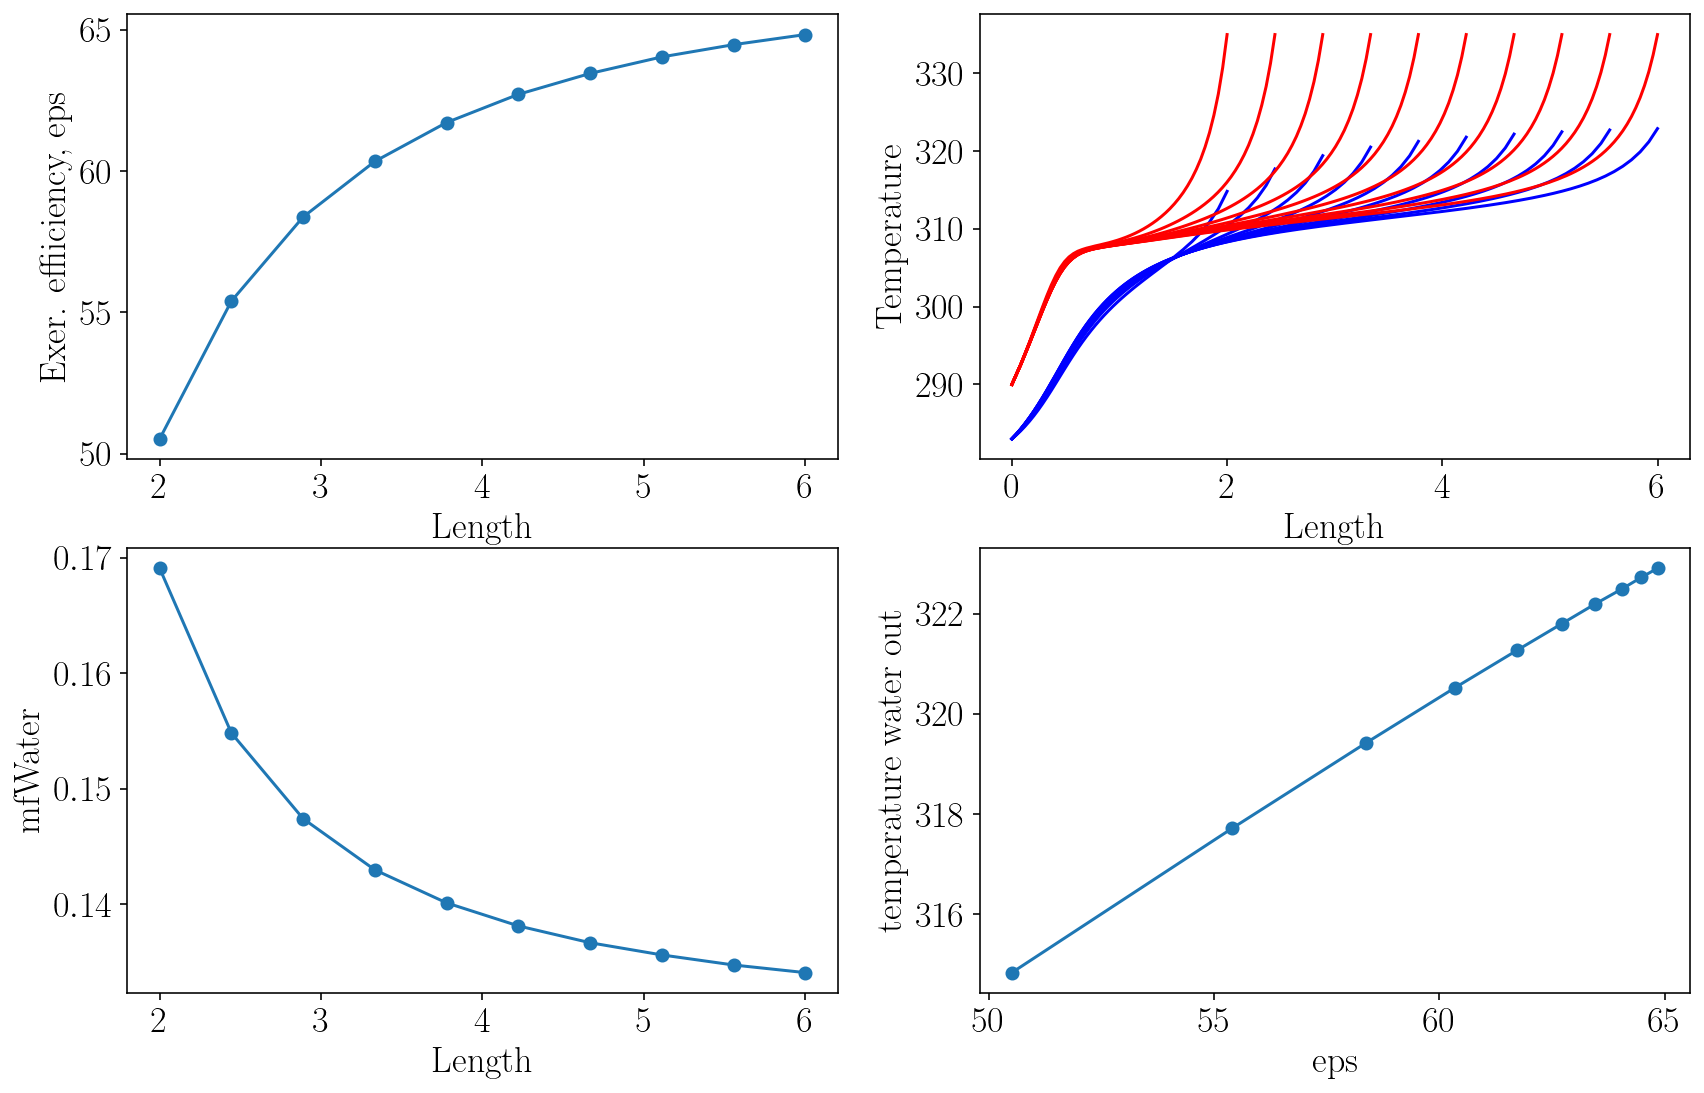

In [17]:
fig, ax = plt.subplots(2,2, figsize=(14,9))
ax[0,0].plot(length_arr, eps_arr, 'o-')
ax[0,0].set_xlabel('Length')
ax[0,0].set_ylabel('Exer. effiiciency, eps')

for i,length in enumerate(length_arr):
    ax[0,1].plot(x_arr[i], Tc_arr[i], 'b-')
    ax[0,1].plot(x_arr[i], Th_arr[i], 'r-')
ax[0,1].set_xlabel('Length')
ax[0,1].set_ylabel('Temperature')

ax[1,0].plot(length_arr, mfWater_arr,'o-')
ax[1,0].set_xlabel('Length')
ax[1,0].set_ylabel('mfWater')

tempWaterOut = []
for i,length in enumerate(length_arr):
    tempWaterOut.append((Tc_arr[i])[-1])
ax[1,1].plot(eps_arr, tempWaterOut,'o-')
ax[1,1].set_xlabel('eps')
ax[1,1].set_ylabel('temperature water out')
